## Set-up


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from helper import *


In [30]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


## Example image


In [31]:
image_path = 'images/14.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


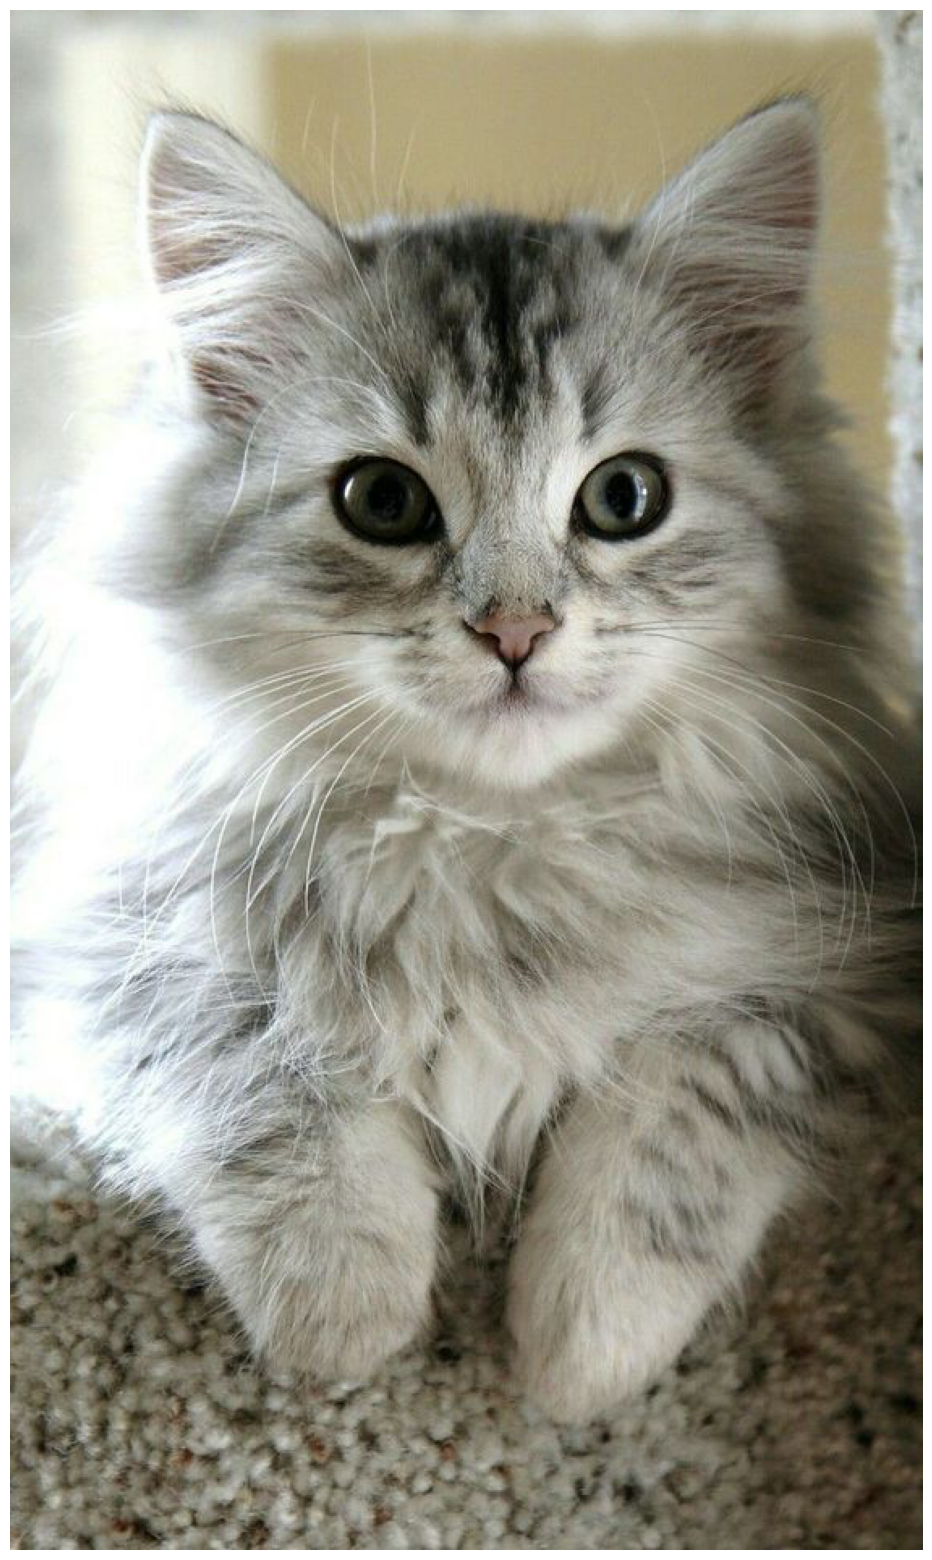

In [32]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Automatic mask generation


To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.


In [5]:
import sys
# sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/susanto/Documents/Proyek/best-remove-background/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

# print(mask_generator)


To generate masks, just run `generate` on an image.


In [34]:
masks = mask_generator.generate(image)


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format


In [ ]:
# print(masks[0])


In [ ]:
# plt.imshow(masks[2]["segmentation"])


In [24]:
print(len(masks))
print(masks[0].keys())


36
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [35]:
# RGB numpy array to RGBA numpy array
rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgba_image[:, :, :3] = image
rgba_image[:, :, 3] = 255


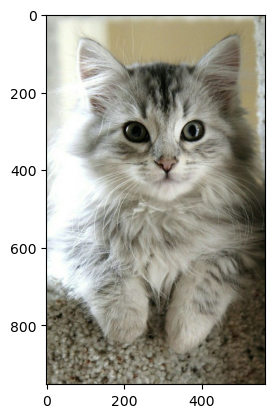

In [36]:
plt.imshow(rgba_image)


In [10]:
from helper import *
from PIL import Image


In [ ]:
# # Make blank image with same size
# base_img = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)


In [37]:


sys.path.append(
    '/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/clustering')


sys.path.append(
    '/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/filter')

from filter import dominantTransparent,detect_dominant_color,dominant_transparent_rgba
from clustering import getMasksColorCluster

In [38]:
def makeCluster(i, bounding, rgba_image, output_folder="output/"):
    # B. Clustering
    x1, y1, x2, y2 = bounding
    d = rgba_image.copy()
    cropped_img = d[y1:y2, x1:x2]

    # Make rgb because clustering can only accept rgb
    rgb_img = cropped_img[:, :, :3]
    rgb_path = output_folder+str(i)+'_c_cluster.jpg'
    Image.fromarray(np.uint8(rgb_img)).save(rgb_path)

    masks_kmeans = getMasksColorCluster(rgb_path, 3)

    for k in range(len(masks_kmeans)):
        mask = masks_kmeans[k]
        image_masked = newMaskApply(cropped_img.copy(), mask)

        result_cluster_path = output_folder+str(i)+'_c_cluster_'+str(k)+'.png'

        PIL_image = Image.fromarray(image_masked.astype('uint8'), 'RGBA')
        PIL_image.save(result_cluster_path, format='PNG')


In [39]:
def makeCanny(i, copied_img, rgba_img_canny, rgba_image, output_folder="output/"):
    # A. Only output if pixel exist on segment and canny
    mask = np.logical_and(copied_img[:, :, 3]
                          != 0, rgba_img_canny[:, :, 3] != 0)
    copied_img_canny = rgba_image.copy()
    negated_mask = ~mask
    copied_img_canny[negated_mask] = [0, 0, 0, 0]

    # Get some box
    file_name = output_folder+str(i)+'_b_canny.png'
    PIL_image, bounding = cropUnusedBlankPixel(copied_img_canny)
    PIL_image.save(file_name)

    return [bounding, file_name]


In [40]:
def useSegmentAnything(last_index, img_path, origin_img, file_name=None, output_folder="output/"):
    new_masks_bounding = []
    new_file_names = []

    if file_name == None:
        file_name = getFileName(img_path)

    output_folder = output_folder+file_name+"_"
    nextId = last_index

    # Make blank image with same size
    base_img = np.zeros(
        (origin_img.shape[0], origin_img.shape[1], 4), dtype=np.uint8)

    # Make canny edge from whole imagge
    edges = canny_edge_detection(origin_img)
    kernel = np.ones((5, 5), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    rgba_img_canny = origin_img.copy()
    rgba_img_canny[closed_edges == 0] = [0, 0, 0, 0]

    for i in range(0, len(masks)):
        # Apply Segment Mask
        segmentation = masks[i]['segmentation']
        copied_img = origin_img.copy()
        copied_img[segmentation == False] = [0, 0, 0, 0]

        # patch all segmentation part into blank image
        maskAll = (base_img[:, :, 3] <= copied_img[:, :, 3])
        base_img[maskAll] = copied_img[maskAll]

        # Save main segment
        new_file_name = output_folder+str(i)+'_a_sam.png'
        PIL_image, bounding = cropUnusedBlankPixel(copied_img)
        PIL_image.save(new_file_name)

        PIL_image = dominant_transparent_rgba(PIL_image)
        PIL_image.save(output_folder+str(i)+'_a_dom.png')

        new_file_names.append([new_file_name, "sam", nextId])
        info = np.array(
            ["bounding_box", new_file_name, bounding], dtype=object)
        new_masks_bounding.append(info)

        # Make canny image and Color Clustering
        makeCanny(nextId, copied_img, rgba_img_canny,
                  origin_img, output_folder)

        nextId += 1

    # Rest are that SAM not detected
    rest = base_img[:, :, 3] != 0
    copied_img = origin_img.copy()
    copied_img[rest] = [0, 0, 0, 0]

    new_file_name = output_folder+str(nextId)+'_a_rest.png'

    PIL_image, bounding = cropUnusedBlankPixel(copied_img)
    PIL_image.save(new_file_name)

    # Send to output
    new_file_names.append([new_file_name, "sam", nextId])
    info = np.array(
        ["bounding_box", new_file_name, bounding], dtype=object)
    new_masks_bounding.append(info)

    # Make Canny Image and Color Clustering
    makeCanny(nextId, origin_img.copy(),
              rgba_img_canny, origin_img, output_folder)

    return [new_masks_bounding, new_file_names]


In [41]:
new_masks_bounding, new_file_names = useSegmentAnything(0, image_path, rgba_image)


dominant_color
(237, 241, 244, 255)


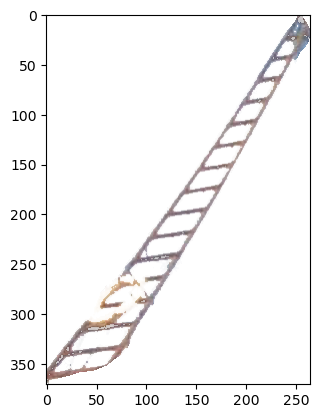

In [ ]:
a = Image.open('images/rope.png')

# dominant_color = detect_dominant_color_rgba(a)

# dominant_color = dominant_color[:3]
# print("dominant_color")
# print(dominant_color)
# plt.imshow(a)
numpy_image = np.array(a)
# print(numpy_image)

trans = dominant_transparent_rgba(a)

trans.save("images/rope_res.png")

plt.imshow(trans)


In [ ]:
# Load the image and convert it to a numpy array
image = Image.open('images/dots.png').convert('RGBA')
arr = np.array(image)

# Define the radius threshold for the dots
radius_threshold = 100

# Loop over each pixel and check if it's close to one of the dots
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        if arr[i,j,3] == 0:  # skip transparent pixels
            continue
        # Check if the pixel is close to one of the dots
        for dot in [(50, 50), (150, 50), (50, 150), (150, 150)]:  # dot positions
            dot_distance = np.sqrt((i - dot[0])**2 + (j - dot[1])**2)
            if dot_distance < radius_threshold:
                # Fill in the transparent pixel between the dot and the current pixel
                arr[i,j-1:j+2,3] = 255

# Convert the modified numpy array back to an image
image = Image.fromarray(arr, mode='RGBA')
image.show()


In [ ]:
print(type(image))


<class 'numpy.ndarray'>


In [46]:
from scipy.ndimage import binary_dilation, binary_erosion

In [47]:
def get_edge_mask(mask):
    # Dilate the mask to get the boundary pixels
    dilated_mask = binary_dilation(mask)
    # Erode the mask to get the interior pixels
    eroded_mask = binary_erosion(mask)
    # Subtract the eroded mask from the dilated mask to get the boundary pixels
    edge_mask = np.logical_and(dilated_mask, np.logical_not(eroded_mask))
    return edge_mask

In [51]:
binary_mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)

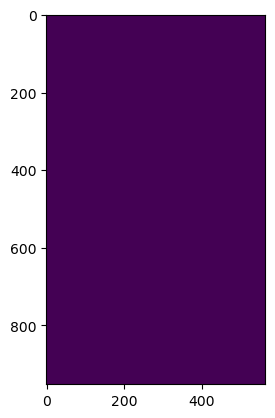

In [52]:
plt.imshow(binary_mask)

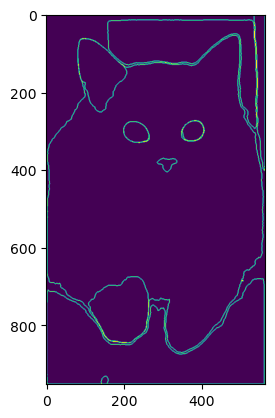

In [53]:
for i in range(0, len(masks)):
    # Apply Segment Mask
    segmentation = masks[i]['segmentation']

    edge = get_edge_mask(segmentation)
    plt.imshow(edge)

    binary_mask=np.logical_or(binary_mask,edge)

plt.imshow(binary_mask)


Show all the masks overlayed on the image.


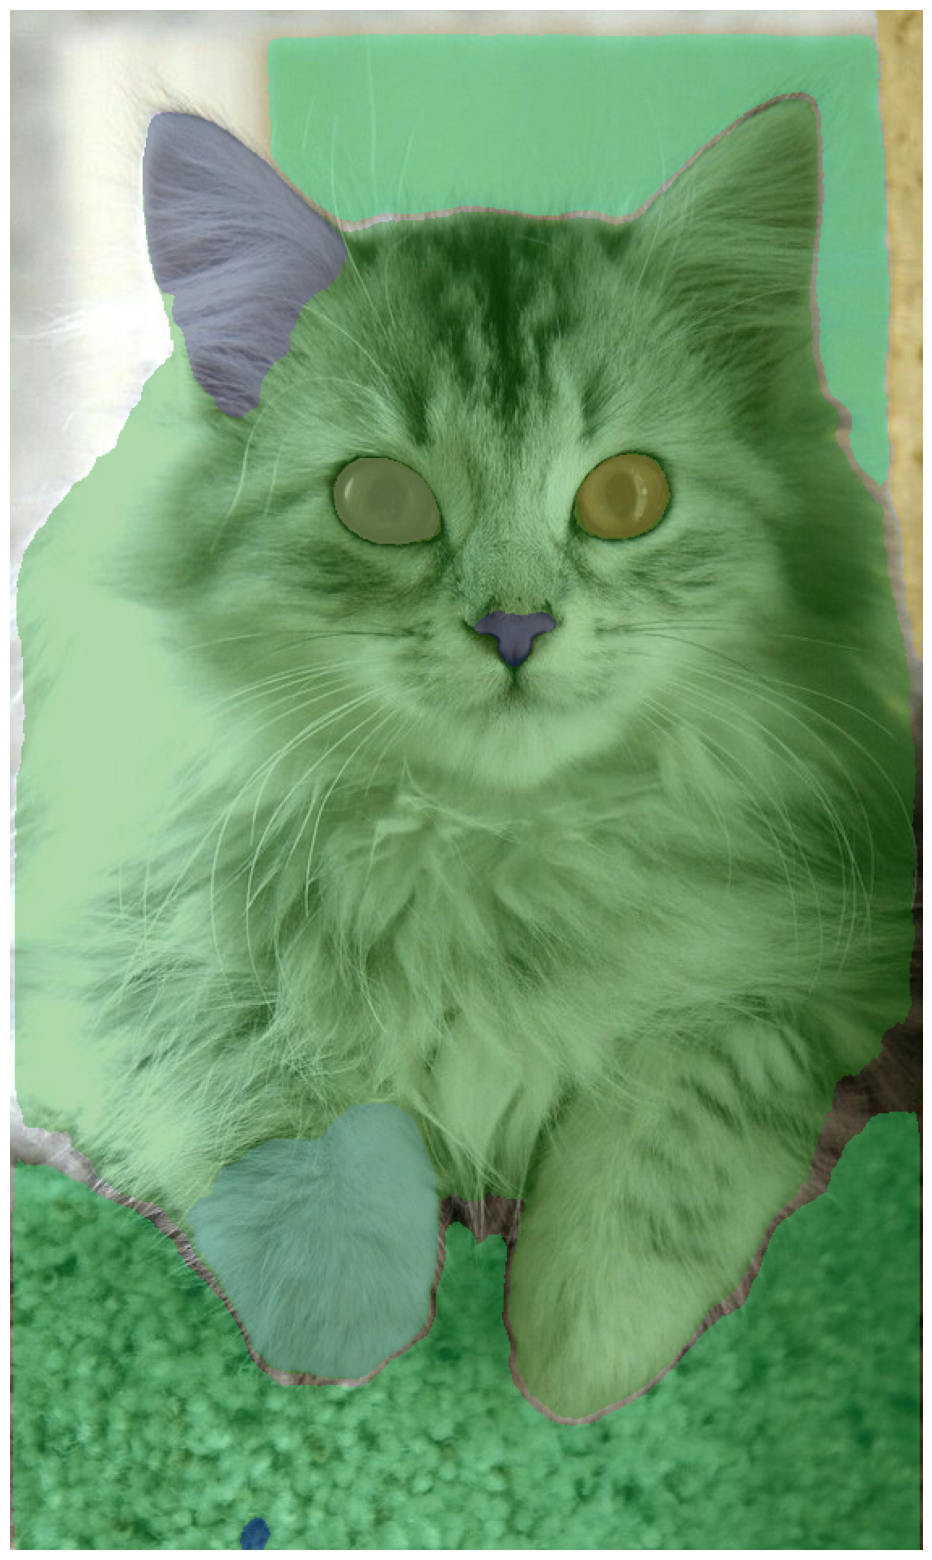

In [42]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


## Automatic mask generation options


There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:


In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


In [ ]:
masks2 = mask_generator_2.generate(image)


In [ ]:
# len(masks2)


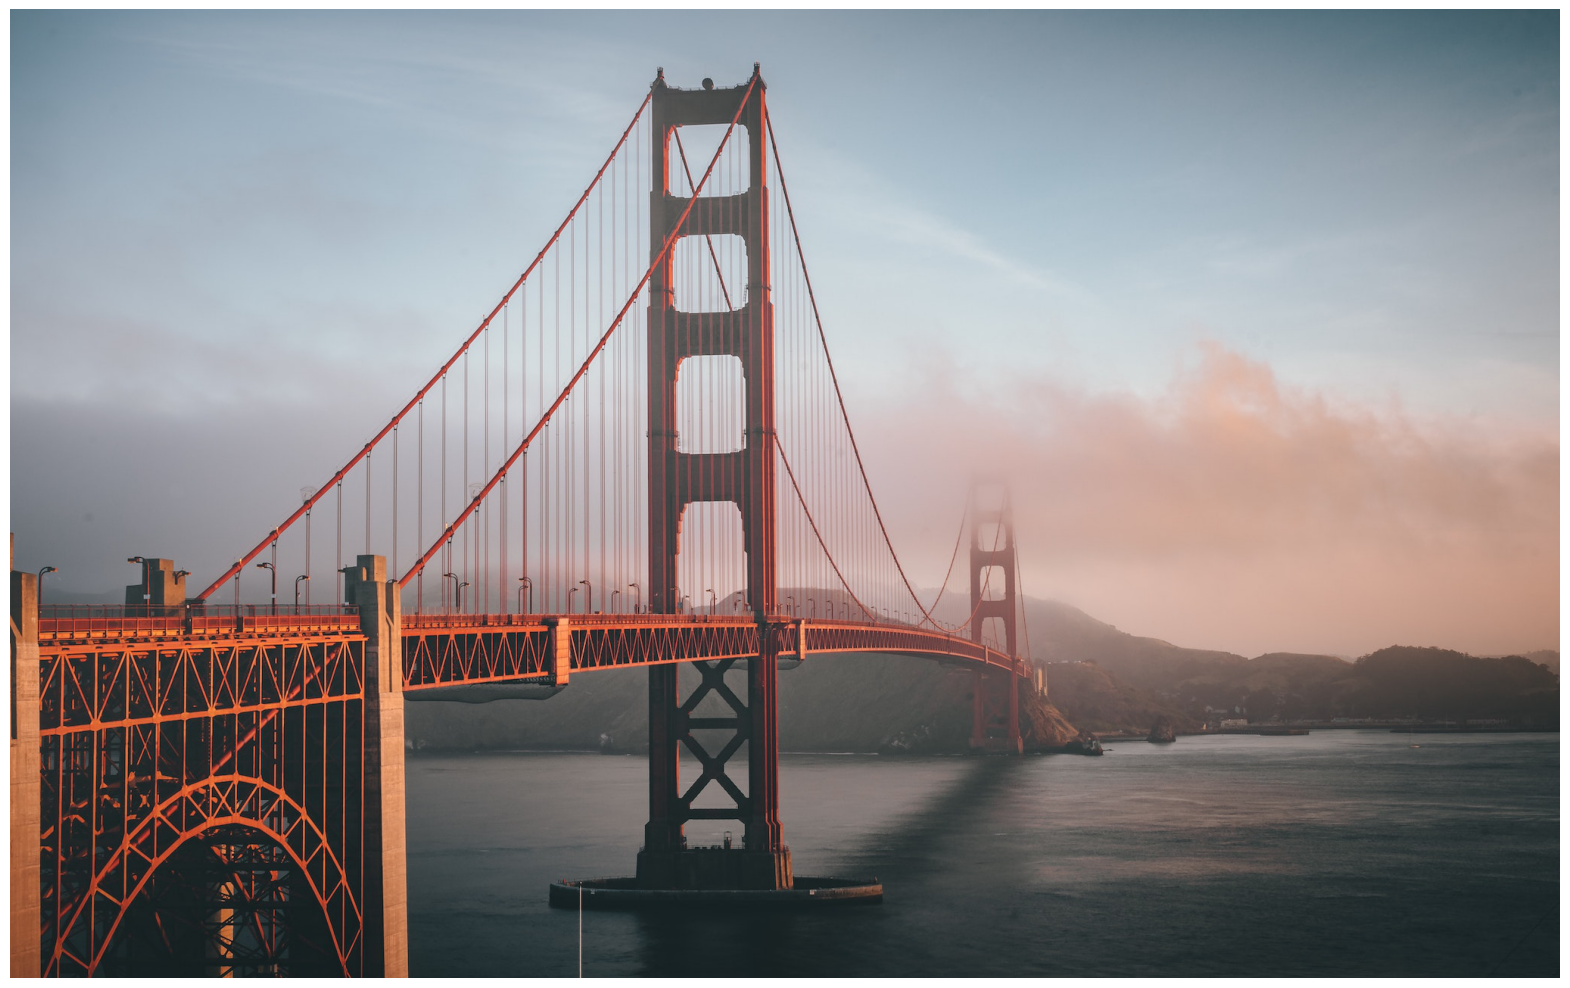

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()
